# Decoding continuous eye movements from cortical spiking activity
### Kendra K. Noneman and J. Patrick Mayo

In [1]:
DATA_FOLDER =  '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs_final/'
FIG_FOLDER  =  '/Users/kendranoneman/Figures/neural-decoding/final_manuscript'

## Packages and functions

In [2]:
# Packages and toolboxes
import numpy as np
import pandas as pd
import os
import sys
import pickle
import cmath
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel

# Colors for each decoding model
cols = ['#dc6d3f','#f1c232','#317c32','#20a693','#358eb9','#3127d7','#a624d7','#d51f89']
cols = [mcolors.to_rgb(col) for col in cols]

grays = ['#f4d3c5','#faecc1','#c1d7c1','#bce4de','#c2ddea','#c1bef3','#e4bdf3','#f2bbdb']
grays = [mcolors.to_rgb(col) for col in grays]

pal_cols = ['#B3AA00','#74B300','#00B315','#00B377','#008CB3','#002DB3','#3C00B3','#8C00B3']
pals = [sns.light_palette(col, as_cmap=True, n_colors=5) for col in cols]

In [3]:
example_data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')
out_times    =  np.squeeze(example_data['vels_times']) # times at which velocities were recorded
sess_size = len(out_times)

In [4]:
# Functions for concatenating pickle files and calculating evaluation metrics
def get_outputs_wTraces(data_folder,conditions,column_names):
    """ 
    Function to get results for each decoder run, concatenated across models, repeats, etc...

    Parameters
    ----------
    data_folder  - path to the folder where data is located 
    conditions   - array of strings, containing labels for conditions you wish to include in data extraction
    column_names - names of columns for data you are pulling out, this varied a little across analyses

    Returns
    -------
    df            - pandas dataframe containing all of the evaluation metrics and labels for each decoder run
    conds_all     - labels for each observation in the test set, including trial conditions and markers
    yTest_all     - actual/recorded eye traces from test set
    yTestPred_all - predicted/decoded eye traces from test set 
    """
    results_all,conds_all,yTest_all,yTestPred_all = [],[],[],[]
    direcs = sorted(os.listdir(data_folder))
    current_direcs = [d for d in direcs if all(c in d for c in conditions)]
    for direc in current_direcs:
        files = sorted(os.listdir(os.path.join(data_folder, direc)))
        for file in files:
            file_path = os.path.join(data_folder, direc, file)
            if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                if file.endswith('.pickle') and ('repeat000.' in file or 'repeat00.' in file):
                    with open(file_path, 'rb') as f:
                        results,conds,y_test,y_test_predicted = pickle.load(f)
                        conds_all.append(conds)
                        results_all.append(results)
                        yTest_all.append(y_test)
                        yTestPred_all.append(y_test_predicted)
                elif file.endswith('.pickle'):
                    with open(file_path, 'rb') as f:
                        results = pickle.load(f)
                        results_all.append(results[0])

    df = pd.DataFrame(results_all,columns=column_names)
    df['R2_x']   = df['R2'].apply(lambda x: x[0])
    df['R2_y']   = df['R2'].apply(lambda x: x[1])
    df['R2_mn']  = df['R2'].apply(lambda x: x.mean())
    df['rho_mn']  = df['rho'].apply(lambda x: x.mean())
    df['R2sh_mn']  = df['R2_shuf'].apply(lambda x: x.mean())
    df['R2tr_mn']  = df['R2_train'].apply(lambda x: x.mean())
    
    return df,conds_all,yTest_all,yTestPred_all

def get_outputs(data_folder, conditions, column_names, lrange=[0,10000], withTraces=False):
    """ 
    Function to get results for each decoder run, concatenated across models, repeats, etc...

    Parameters
    ----------
    data_folder  - path to the folder where data is located 
    conditions   - array of strings, containing labels for conditions you wish to include in data extraction
    column_names - names of columns for data you are pulling out, this varied a little across analyses

    Returns
    -------
    df            - pandas dataframe containing all of the evaluation metrics and labels for each decoder run
    yTestPred_all - predicted/decoded eye traces from test set 
    """
    results_all, yp_test_all = [], []

    # Get sorted list of directories in data_folder
    direcs = sorted(os.listdir(data_folder))
    
    def extract_number(direc_name):
        """Extract the first number from the directory name."""
        parts = direc_name.split('-')
        if parts and parts[0].isdigit():
            return int(parts[0])
        return None

    # Filter directories based on conditions and number range
    current_direcs = [
        d for d in direcs 
        if all(c in d for c in conditions) and extract_number(d) is not None and lrange[0] <= extract_number(d) <= lrange[1]
    ]

    # Filter directories based on conditions
    #current_direcs = [d for d in direcs if all(c in d for c in conditions)]

    # Iterate over filtered directories
    for direc in current_direcs:
        files = sorted(os.listdir(os.path.join(data_folder, direc)))
        for file in files:
            file_path = os.path.join(data_folder, direc, file)
            # Check if file exists and is non-empty
            if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                with open(file_path, 'rb') as f:  
                    if withTraces is True:
                        # Load data from file
                        results, yp_test = pickle.load(f)
                        # Append to lists
                        results_all.append(results)
                        #yp_train_all.append(yp_train)
                        yp_test_all.append(yp_test)
                    else:
                        # Load data from file
                        results, _ = pickle.load(f)
                        # Append to lists
                        results_all.append(results)
                        yp_test_all = 0

    # Create DataFrame from results_all list
    df = pd.DataFrame(results_all, columns=column_names)
    
    df['R2_test_mn']  = df['R2_test'].apply(lambda x: x.mean())
    df['rho_test_mn']  = df['rho_test'].apply(lambda x: x.mean())
    df['rmse_test_mn']  = df['rmse_test'].apply(lambda x: x.mean())
    df['R2_train_mn']  = df['R2_train'].apply(lambda x: x.mean())
    df['rho_train_mn']  = df['rho_train'].apply(lambda x: x.mean())
    df['rmse_train_mn']  = df['rmse_train'].apply(lambda x: x.mean())

    return df, yp_test_all

def get_actualTraces(data_folder, df):
    output_mapping = {"position": 0, "velocity": 1, "acceleration": 2}
    
    y_test_all,c_test_all = [],[]
    # Iterate over rows and format string
    for index, row in df.iterrows():
        file = "actual-s{:02d}-t{:01d}-dto{:03d}-df{:01d}-o{:d}-fold{:0>1d}.pickle".format(
            row["sess"], 
            row["timePrePost"], 
            row["output_binWidth"], 
            row["downsample_factor"], 
            output_mapping.get(row["output"], None), 
            row["outer_fold"])
        
        file_path = os.path.join(data_folder, 'actual/', file)
        with open(file_path, 'rb') as f:
            # Load data from file
            y_test, c_test = pickle.load(f)
            # Append to lists
            #y_train_all.append(y_train)
            #c_train_all.append(c_train)
            y_test_all.append(y_test)
            c_test_all.append(c_test)

    return y_test_all, c_test_all

def get_R2(y_test,y_test_pred):

    """
    Function to get R2

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    R2_array: An array of R2s for each output
    """
    y_mean = np.mean(y_test, axis=0)
    numer = np.sum((y_test_pred - y_test) ** 2, axis=0)
    denom = np.sum((y_test - y_mean) ** 2, axis=0)

    R2 = 1 - numer / denom #Append R2 of this output to the list

    return R2  #Return an array of R2s

def adjust_R2(R2,num_observations,num_predictors):

    adjusted_R2 = 1 - (1 - R2) * (num_observations - 1) / (num_observations - num_predictors - 1)

import numpy as np

def get_rho(y_test, y_test_pred):
    """
    Function to get Pearson's correlation (rho)

    Parameters
    ----------
    y_test : numpy array
        The true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred : numpy array
        The predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    rho_array : numpy array
        An array of rho's for each output
    """

    rho_array = np.empty(y_test.shape[1])  # Create a 1D array to store correlation coefficients
    for i in range(y_test.shape[1]):  # Loop through outputs
        # Compute rho for each output
        rho_array[i] = np.corrcoef(y_test[:, i], y_test_pred[:, i])[0, 1]

    return rho_array  # Return an array of correlation coefficients

def get_RMSE(y_test, y_test_pred):
    """ 
    Function to get RMSE

    Parameters
    ----------
    y_test : numpy array
        The true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred : numpy array
        The predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    RMSE_array : numpy array
        An array of RMSEs for each output
    """
    num_outputs = y_test.shape[1]

    RMSE_array = np.sqrt(np.mean((y_test_pred - y_test) ** 2, axis=0))

    return RMSE_array

######## BIN_SPIKES ########
def bin_spikes(spike_times,dt,wdw_start,wdw_end):
    """ 
    Function that puts spikes into bins

    Parameters
    ----------
    spike_times: an array of arrays
        an array of neurons. within each neuron's array is an array containing all the spike times of that neuron
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for putting spikes in bins
    wdw_end: number (any format)
        the end time for putting spikes in bins

    Returns
    -------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    """
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1 #Number of bins
    num_neurons=spike_times.shape[0] #Number of neurons
    neural_data=np.empty([num_bins,num_neurons]) #Initialize array for binned neural data
    #Count number of spikes in each bin for each neuron, and put in array
    for i in range(num_neurons):
        neural_data[:,i]=np.histogram(spike_times[i],edges)[0]
    
    return neural_data

######## BIN_OUTPUT #######
def bin_output(outputs,output_times,dt,wdw_start,wdw_end,downsample_factor=1):
    """ 
    Function that puts outputs into bins

    Parameters
    ----------
    outputs: matrix of size "number of times the output was recorded" x "number of features in the output"
        each entry in the matrix is the value of the output feature
    output_times: a vector of size "number of times the output was recorded"
        each entry has the time the output was recorded
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for binning the outputs
    wdw_end: number (any format)
        the end time for binning the outputs
    downsample_factor: integer, optional, default=1
        how much to downsample the outputs prior to binning
        larger values will increase speed, but decrease precision

    Returns
    -------
    outputs_binned: matrix of size "number of time bins" x "number of features in the output"
        the average value of each output feature in every time bin
    """

    ###Downsample output###
    #We just take 1 out of every "downsample_factor" values#
    if downsample_factor!=1: #Don't downsample if downsample_factor=1
        downsample_idxs=np.arange(0,output_times.shape[0],downsample_factor) #Get the idxs of values we are going to include after downsampling
        outputs=outputs[downsample_idxs,:] #Get the downsampled outputs
        output_times=output_times[downsample_idxs] #Get the downsampled output times

    ###Put outputs into bins###
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1
    output_dim=outputs.shape[1]
    outputs_binned=np.empty([num_bins,output_dim])
    #Loop through bins, and get the mean outputs in those bins
    for i in range(num_bins):
        idxs=(np.squeeze(output_times)>=edges[i]) & (np.squeeze(output_times)<edges[i+1])
        outputs_binned[i,:] = outputs[idxs,:].mean(axis=0)

    return outputs_binned,edges

def get_exTrialLabels(df,conds,y_test,y_test_predicted,o=None,mdl=None,fold=0,dto=50,gi=1):
    base_condition = (df['outer_fold'] == fold) & (df['output_binWidth'] == dto)
    
    if mdl is not None:
        base_condition &= (df['model'] == mdl)
    
    if o is not None:
        base_condition &= (df['output'] == o)
    
    trls = base_condition
    
    c = conds[df[trls].index.values[0]]
    y = y_test[df[trls].index.values[0]]
    yp = y_test_predicted[df[trls].index.values[0]]
    
    trl_nums, indices = np.unique(c[:,0], return_index=True)
    trl_dirs = c[indices,3]
    
    R2_all = []
    for t in trl_nums:
        start_end = np.where(np.isin(c[:, 0],t))[0]

        X_true = y[start_end,0]
        Y_true = y[start_end,1]

        X_pred = yp[start_end,0]
        Y_pred = yp[start_end,1]
        
        R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
        R2_all.append(R2.mean())

    R2_all = np.array(R2_all)
    
    ex_trials = []
    for d in np.sort(np.unique(trl_dirs)):
        d_indices = np.where(trl_dirs == d)[0]
        d_R2 = R2_all[d_indices]
        d_trl = trl_nums[d_indices]
        d_dir = trl_dirs[d_indices]
        
        sorted_indices = np.argsort(d_R2)
        
        if gi==1:
            ex_trials.extend(d_trl[sorted_indices[-gi:]].astype(int))
        else:
            ex_trials.extend(d_trl[sorted_indices[-gi:-(gi-1)]].astype(int))
    
    return ex_trials

def get_eyeTraces(df,conds,y_test,y_test_predicted,o='position',mdl=7,fold=0,dto=50,dti=50,wi=400,trls=None):
    c = conds[df[(df['outer_fold'] == fold) & (df['output'] == o) & (df['output_binWidth'] == dto) & (df['input_binWidth'] == dti) & (df['input_timeWindow'] == wi) & (df['model'] == mdl)].index.values[0]]
    y = y_test[df[(df['outer_fold'] == fold) & (df['output'] == o) & (df['output_binWidth'] == dto) & (df['input_binWidth'] == dti) & (df['input_timeWindow'] == wi) & (df['model'] == mdl)].index.values[0]]
    yp = y_test_predicted[df[(df['outer_fold'] == fold) & (df['output'] == o) & (df['output_binWidth'] == dto) & (df['input_binWidth'] == dti) & (df['input_timeWindow'] == wi) & (df['model'] == mdl)].index.values[0]]
    
    if trls is not None:
        inds = np.where(np.isin(c[:,0],trls))[0]
        ya, yp = y[inds,:], yp[inds,:]
    else:
        ya, yp = y, yp
    
    return ya, yp

def get_dfVal_folds(df,dto=50,dti=50,wi=400,o='position',val='R2'):
    wf = (df.loc[(df['model']==0) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    wc = (df.loc[(df['model']==1) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    xgb = (df.loc[(df['model']==2) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    svr = (df.loc[(df['model']==3) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    dnn = (df.loc[(df['model']==4) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    rnn = (df.loc[(df['model']==5) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    gru = (df.loc[(df['model']==6) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    lstm = (df.loc[(df['model']==7) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    
    return wf,wc,xgb,svr,dnn,rnn,gru,lstm

def get_goodSessions(df,min_r2,dto=50,dti=50,wi=400,o='position',em='R2',val='r2_test_mn'):
    session_means = []
    for i,s in enumerate(df['sess'].unique()):
        #if s==22 or s==33 or s==36:#s==39 or s==28 or s==23 or s==27:
        #    continue
        #else:
        wf,wc,xgb,svr,dnn,rnn,gru,lstm = get_dfVal_folds(df.loc[(df['sess']==s)],dto=dto,dti=dti,wi=wi,o=o,em=em,val=val)
            
        n=10
        means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])    
        err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])
        
        session_means.append(np.mean(means))
        
    print(session_means)
    print(blah)
        
        #if np.any(np.array(means) < min_r2):
        #    continue
        #else:
        #    sessions.append(s)
                
    return sessions

def gen_gap(tr,te):
    return 100*((te-tr)/(tr))
    #return 1*((te-tr))

def calc_evalMetrics(df,sess_size,minR2):
    df = df[df['R2_mn'] >= minR2]
    
    df['num_obs']      =  sess_size / df['output_binWidth'] # number of total observations
    df['num_feat'] =  df['input_timeWindow'] / df['input_binWidth'] # number of features
    
    # training time
    df['train_time']    =  df['train_time'] / 60   # convert time to sec
    
    # inference latency
    df['preProcessTime_corrected'] =  df['preProcess_time'] / df['num_obs']
    df['inference_time']           =  df['test_time'] + df['preProcessTime_corrected']
    
    # generalization gap
    df['robust_diff'] =  ((df['R2tr_mn'] - df['R2_mn']) / df['R2tr_mn']) * 100
    
    return df
    

## Figure 1. Decoding pipeline and example trials

In [81]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, yp_test = get_outputs(DATA_FOLDER,["-s29-","r0001"],column_names,lrange=[0,239],withTraces=True) # position
ya_test, c_test = get_actualTraces(DATA_FOLDER, df)

# Get trial numbers for "best" trial in each direction, will be used for all eye traces plots
#plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,o='position',fold=0,mdl=7,gi=13)
plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,fold=0,o='acceleration',gi=1)
print(plot_trls)

df.head(3)

[1068, 912, 938, 1015]


,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,15,29,0,50,1,400,50,65,24,41,...,"[2.5313971158537756, 2.5354085427982835]","[0.6967174842812609, 0.764417009439726]","[[0.8351590899362642, 0.8757743752053944]]","[2.630727579057303, 2.51912585996959]",0.730567,0.855467,2.574927,0.734125,0.856719,2.533403
1,15,29,0,50,1,400,50,65,24,41,...,"[2.523750275257501, 2.534381800135432]","[0.6802569482005805, 0.7601311296566597]","[[0.8347804300673948, 0.872420499132053]]","[2.6930217624982475, 2.539350074554998]",0.720194,0.853600,2.616186,0.735837,0.857728,2.529066
2,15,29,0,50,1,400,50,65,24,41,...,"[2.5374785155470865, 2.5301053254158528]","[0.7072641973421873, 0.7534570128261007]","[[0.8464654241912434, 0.8749482222381165]]","[2.555384524576792, 2.5236440814437304]",0.730361,0.860707,2.539514,0.735455,0.857484,2.533792


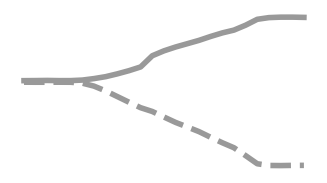

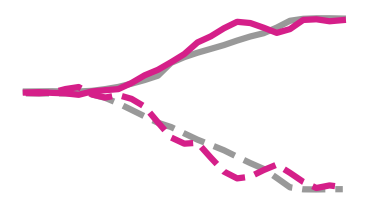

In [82]:
####### (a) example traces for single trial, actual eye traces and predicted eye traces ###########

#pipe_trl = 1861

# example recorded eye trace
fig, ax = plt.subplots(figsize=(4.5, 2.75))
fig.tight_layout()

y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=7,fold=0,trls=plot_trls[1])
x = np.linspace(0,1*1600,y_true.shape[0])

ax.plot(x,y_true[:,0],linewidth=4,linestyle='dashed',color=(0.6,0.6,0.6))
ax.plot(x,y_true[:,1],linewidth=4,linestyle='solid',color=(0.6,0.6,0.6))

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(FIG_FOLDER+'/actual_eyeTrace.png', dpi=600, bbox_inches='tight')

# example recorded/decoded eye trace
fig, ax = plt.subplots(figsize=(5, 3))
fig.tight_layout()

y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=7,fold=0,trls=plot_trls[1])
x = np.linspace(0,1*1600,y_true.shape[0])

ax.plot(x,y_true[:,0],linewidth=4.5,linestyle='dashed',color=(0.6,0.6,0.6))
ax.plot(x,y_true[:,1],linewidth=4.5,linestyle='solid',color=(0.6,0.6,0.6))

ax.plot(x,y_pred[:,0],linewidth=4.5,linestyle='dashed',color=cols[7])
ax.plot(x,y_pred[:,1],linewidth=4.5,linestyle='solid',color=cols[7])

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(FIG_FOLDER+'/actualDecoded_eyeTrace.png', dpi=600, bbox_inches='tight')

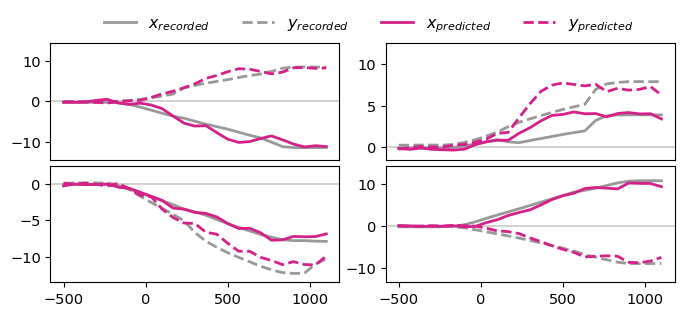

In [84]:
fig, axes = plt.subplots(2,2,figsize=(7,3)) #6,5.5
plt.rcParams.update({'font.size': 10.5})
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=7,fold=0,trls=plot_trls[i])
    x = np.linspace(0-500,(1*1600)-500,y_true.shape[0])

    ax.plot(x,y_true[:,0],linewidth=2,linestyle='solid',color=(0.6,0.6,0.6),label='$x_{recorded}$')
    ax.plot(x,y_true[:,1],linewidth=2,linestyle='dashed',color=(0.6,0.6,0.6),label='$y_{recorded}$')

    ax.plot(x,y_pred[:,0],linewidth=2,linestyle='solid',color=cols[7],label='$x_{predicted}$')
    ax.plot(x,y_pred[:,1],linewidth=2,linestyle='dashed',color=cols[7],label='$y_{predicted}$')
    
    ax.axhline(0, color='black', linestyle='-',linewidth=0.25,zorder=0)  # Dashed line at y=0
    #plt.axvline(0, color='gray', linestyle='--')  # Dashed line at x=0

plt.subplots_adjust(wspace=0.16, hspace=0.05)
    
pos1 = axes[0,0].get_position()
axes[0,0].set_position(axes[0,1].get_position())
axes[0,1].set_position(pos1)

axes[0,0].set_ylim(-1.5,12.5)
axes[0,1].set_ylim(-14.5,14.5)
axes[1,0].set_ylim(-13.5,2.5)
axes[1,1].set_ylim(-13.5,14.5)

axes[0,0].set_xticks([])
axes[0,1].set_xticks([])
axes[1,0].set_xticks([-500,0,500,1000])
axes[1,0].set_xticks([-500,0,500,1000])

axes[0,1].legend(loc='lower center', bbox_to_anchor=(1.1, 0.95),
          fancybox=False, shadow=False, ncol=4, fontsize="11.5",frameon=False)

fig.savefig(FIG_FOLDER+'/model_4traces_subplots.png', dpi=600, bbox_inches='tight')

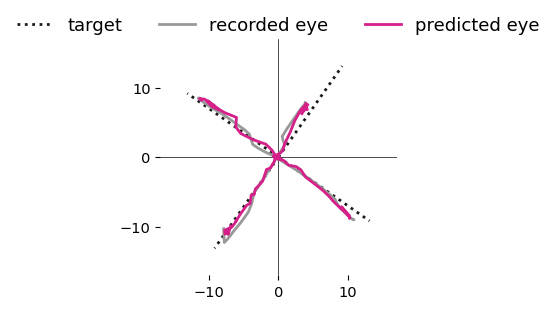

In [85]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(7.5, 3))
plt.rcParams.update({'font.size': 11.5})
fig.tight_layout()

# Generate example data (replace this with your actual data)
handles = []
labels = []
# Plotting lines starting from (0, 0) to the calculated endpoints
for i, angle_deg in enumerate([55, 145, 235, 325]):
    angle_rad = np.radians(angle_deg)
    line_length = 16
    endpoint = (line_length * np.cos(angle_rad), line_length * np.sin(angle_rad))
    
    line, = ax.plot([0, endpoint[0]], [0, endpoint[1]], color=(0.1, 0.1, 0.1), linestyle=':', linewidth=2, zorder=1)
    if i == 0:
        handles.append(line)
        labels.append('target')
        
for i in range(4):
    y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=7,fold=0,trls=plot_trls[i])
    
    # Plot the true eye traces
    true_line, = ax.plot(y_true[:, 0], y_true[:, 1], linewidth=2, linestyle='solid', color=(0.6, 0.6, 0.6), zorder=2)
    if i == 0:
        handles.append(true_line)
        labels.append('recorded eye')
    
    decoded_line, = ax.plot(y_pred[:, 0], y_pred[:, 1], linewidth=2, linestyle='solid', color=cols[7], zorder=3)
    if i == 0:
        handles.append(decoded_line)
        labels.append('predicted eye')

ax.axhline(0, color='black', linestyle='-',linewidth=0.5,zorder=0)  # Dashed line at y=0
ax.axvline(0, color='black', linestyle='-',linewidth=0.5,zorder=0)  # Dashed line at x=0

plt.gca().set_aspect('equal', adjustable='box')

# Create legend with custom handles and labels
ax.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(0.5, 0.95),
          fancybox=False, shadow=False, ncol=3, fontsize="13", frameon=False)

ax.set_xlim([-17,17])
ax.set_xticks([-10,0,10])
ax.set_ylim([-17,17])
ax.set_yticks([-10,0,10])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.gca().set_aspect('equal', adjustable='box')

fig.savefig(FIG_FOLDER+'/model_4traces.png', dpi=600, bbox_inches='tight')

In [ ]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(7.5, 3))
plt.rcParams.update({'font.size': 13})
fig.tight_layout()

# Generate example data (replace this with your actual data)
handles = []
labels = []
# Plotting lines starting from (0, 0) to the calculated endpoints
for i, angle_deg in enumerate([55, 145, 235, 325]):
    angle_rad = np.radians(angle_deg)
    line_length = 16
    endpoint = (line_length * np.cos(angle_rad), line_length * np.sin(angle_rad))
    
    line, = ax.plot([0, endpoint[0]], [0, endpoint[1]], color=(0.1, 0.1, 0.1), linestyle=':', linewidth=2, zorder=1)
    if i == 0:
        handles.append(line)
        labels.append('target')
        
for i in range(4):
    y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=7,fold=0,trls=plot_trls[i])
    
    # Plot the true eye traces
    true_line, = ax.plot(y_true[:, 0], y_true[:, 1], linewidth=2, linestyle='solid', color=(0.6, 0.6, 0.6), zorder=2)
    if i == 0:
        handles.append(true_line)
        labels.append('recorded eye')
    
    decoded_line, = ax.plot(y_pred[:, 0], y_pred[:, 1], linewidth=2, linestyle='solid', color=(82/255,118/255,225/255), zorder=3)
    if i == 0:
        handles.append(decoded_line)
        labels.append('predicted eye')

ax.axhline(0, color='black', linestyle='-',linewidth=0.5,zorder=0)  # Dashed line at y=0
ax.axvline(0, color='black', linestyle='-',linewidth=0.5,zorder=0)  # Dashed line at x=0

plt.gca().set_aspect('equal', adjustable='box')

# Create legend with custom handles and labels
ax.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(0.5, 0.95),
          fancybox=False, shadow=False, ncol=3, fontsize="13", frameon=False)

ax.set_xlim([-17,17])
ax.set_xticks([-10,0,10])
ax.set_ylim([-17,17])
ax.set_yticks([-10,0,10])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.gca().set_aspect('equal', adjustable='box')

fig.savefig('/Users/kendranoneman/Posters/ETRA-2024/model_4traces.png', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4.25,2.75)) #6,5.5
plt.rcParams.update({'font.size': 11})
fig.tight_layout()

val = 'R2_test_mn'
wf,wc,xgb,svr,dnn,rnn,gru,lstm = get_dfVal_folds(df,o='position',ml=240,val=val)

#if val=='rmse_test_mn' or val=='rmse_train_mn':
#    for i in range(10):
#        #yr_true, yr_pred = get_eyeTraces(df,c_train,ya_train,yp_train,o='position',mdl=3,fold=i)
#        ye_true, ye_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=3,fold=i)
#        svr[i] = get_RMSE(ye_true, ye_pred * np.std(yr_true,axis=0)).mean()

n=10
means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

ind = np.arange(len(err)) #X values for plotting
for pos, y, yerr, color in zip(ind, means, err, cols): #Loop through methods and plot error bars
    ax.errorbar(pos, y, yerr, lw=2.5, capsize=7.5, capthick=2, color=(82/255,118/255,225/255))

    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0)
    #ax.set_yticks([0.7,0.8,0.9])
    #ax.set_ylim([0.6,0.95])

    #Remove right and top boundaries, and make ticks inward
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    #Plot individual R2 values for each fold as an 'x'
    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(8)),(80,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    #scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(7)),(70,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting
    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
    for i in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(cols[i])
        
    ax.scatter(scatter_x,scatter_y,c=(82/255,118/255,225/255),marker='x',s=60,alpha=0.04)

#fig.savefig(FIG_FOLDER+'/r2_10folds.png', dpi=600, bbox_inches='tight')
fig.savefig('/Users/kendranoneman/Posters/ETRA-2024/r2_10folds.png', dpi=600, bbox_inches='tight')

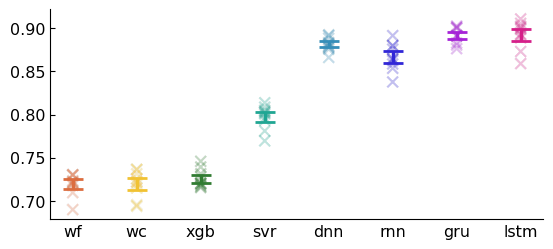

In [86]:
fig, ax = plt.subplots(1,1,figsize=(5.75,2.75)) #6,5.5
plt.rcParams.update({'font.size': 11.5})
fig.tight_layout()

val = 'R2_test_mn'
wf,wc,xgb,svr,dnn,rnn,gru,lstm = get_dfVal_folds(df,o='position',val=val)

#if val=='rmse_test_mn' or val=='rmse_train_mn':
#    for i in range(10):
#        #yr_true, yr_pred = get_eyeTraces(df,c_train,ya_train,yp_train,o='position',mdl=3,fold=i)
#        ye_true, ye_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=3,fold=i)
#        svr[i] = get_RMSE(ye_true, ye_pred * np.std(yr_true,axis=0)).mean()

n=10
means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

ind = np.arange(len(err)) #X values for plotting
for pos, y, yerr, color in zip(ind, means, err, cols): #Loop through methods and plot error bars
    ax.errorbar(pos, y, yerr, lw=2.5, capsize=7.5, capthick=2, color=color)

    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0)
    #ax.set_yticks([0.7,0.8,0.9])
    #ax.set_ylim([0.6,0.95])

    #Remove right and top boundaries, and make ticks inward
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    #Plot individual R2 values for each fold as an 'x'
    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(8)),(80,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    #scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(7)),(70,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting
    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
    for i in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(cols[i])
     
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',s=60,alpha=0.04)

    
fig.savefig(FIG_FOLDER+'/r2_10folds.png', dpi=600, bbox_inches='tight')

## Figure 2. Detailed decoding schematic

In [ ]:
dt = 50
data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
vel         =  data['vels']
acc          =  data['acc']
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']
print(np.unique(conditions[:,0]).shape)

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.175)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.175)].index

print(fef.shape[0] + mt.shape[0])
    
##############################################################################################
#trial = [1861] #1858. 1861. 1879. 1882. 1883.

trls = [plot_trls[3]]
trls = [1858,1861]

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trls))[0][0], sublist<np.where(np.isin(conditions[:,0],trls))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10.2, 3))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


#fig.savefig(FIG_FOLDER+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2a, ax = plt.subplots(figsize=(10.2, 2.25))
fig2a.tight_layout()

poses = pos[np.isin(conditions[:,0],trls)]
ttt = 4
print([poses[320*ttt:320*(ttt+1),1].mean(),poses[320*ttt:320*(ttt+1),0].mean()])

ax.plot((poses[:,0]), label='HE', color='gray', linestyle='--', linewidth=3)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='-', linewidth=3)

#ax.axvline(x=3000, color='red', linestyle='--')
#ax.axvline(x=3200, color='red', linestyle='--')

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig2a.savefig(FIG_FOLDER+'/examp_eyepos.png', dpi=600, bbox_inches='tight');

In [ ]:
saveFigs = 1

dt = 50
data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
vel         =  data['vels']
acc          =  data['acc']
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['BrainArea'] == 'FEF') & (unts['SNR'] > 4) & (unts['mnFR_bestDir'] < 30)].index
mt = unts[(unts['BrainArea'] == 'MT') & (unts['SNR'] > 1) & (unts['mnFR_bestDir'] < 30)].index

print(fef.shape[0])
print(mt.shape[0])
    
##############################################################################################
#trial = [1861] #1858. 1861. 1879. 1882. 1883.

trls = plot_trls[0:2]
#trls = [1858,1861]

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trls))[0][0], sublist<np.where(np.isin(conditions[:,0],trls))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(15, 1.5))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig.savefig(FIG_FOLDER+'/examp_spikes_crossVal.png', dpi=600, bbox_inches='tight')

##############################################################
fig2a, ax = plt.subplots(figsize=(15, 1.5))
fig2a.tight_layout()

trls = [plot_trls[0], plot_trls[1], plot_trls[2], plot_trls[3], 1861, 1858, 1879, 1882, 1883, 1861, 1862]

poses = pos[np.isin(conditions[:,0],trls)]
ttt = 4
print([poses[320*ttt:320*(ttt+1),1].mean(),poses[320*ttt:320*(ttt+1),0].mean()])

ax.plot((poses[:,0]), label='HE', color='gray', linestyle='--', linewidth=3)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='-', linewidth=3)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig2a.savefig(FIG_FOLDER+'/examp_eyepos_crossVal.png', dpi=600, bbox_inches='tight');

## Figure 3. Eye kinematic reconstructions

In [87]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, yp_test = get_outputs(DATA_FOLDER,["s29","r0001"],column_names,lrange=[0,239],withTraces=True) # position
ya_test, c_test = get_actualTraces(DATA_FOLDER, df)

# Get trial numbers for "best" trial in each direction, will be used for all eye traces plots
#plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,o='acceleration',fold=0,mdl=7,gi=1)
plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,fold=0,o='acceleration',gi=1)

print(plot_trls)

df.head(3)

[1068, 912, 938, 1015]


,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,15,29,0,50,1,400,50,65,24,41,...,"[2.5313971158537756, 2.5354085427982835]","[0.6967174842812609, 0.764417009439726]","[[0.8351590899362642, 0.8757743752053944]]","[2.630727579057303, 2.51912585996959]",0.730567,0.855467,2.574927,0.734125,0.856719,2.533403
1,15,29,0,50,1,400,50,65,24,41,...,"[2.523750275257501, 2.534381800135432]","[0.6802569482005805, 0.7601311296566597]","[[0.8347804300673948, 0.872420499132053]]","[2.6930217624982475, 2.539350074554998]",0.720194,0.853600,2.616186,0.735837,0.857728,2.529066
2,15,29,0,50,1,400,50,65,24,41,...,"[2.5374785155470865, 2.5301053254158528]","[0.7072641973421873, 0.7534570128261007]","[[0.8464654241912434, 0.8749482222381165]]","[2.555384524576792, 2.5236440814437304]",0.730361,0.860707,2.539514,0.735455,0.857484,2.533792


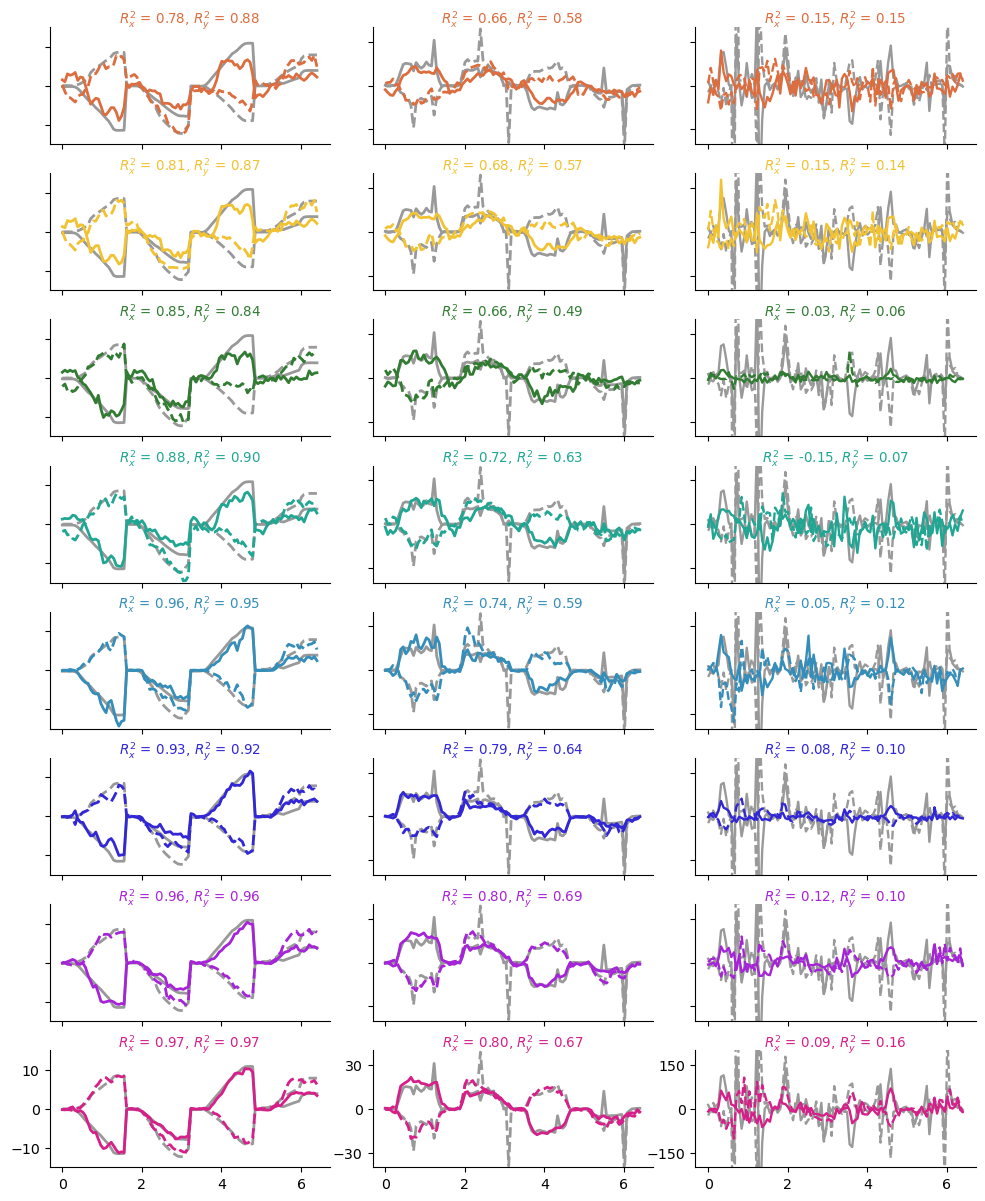

In [91]:
fig, axes = plt.subplots(len(df['model'].unique()),3,figsize=(10,12), sharex=True, sharey=False)
plt.rcParams.update({'font.size': 10.2})
fig.tight_layout()

lws = [2,2,1.7]

for r, mod in enumerate(df['model'].unique()):
    for c, kin in enumerate(df['output'].unique()):
        y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o=kin,mdl=mod,fold=0,trls=plot_trls)
        x = np.linspace(0,4*1.6,y_true.shape[0])

        axes[r,c].plot(x,y_true[:,0],linewidth=lws[c],linestyle='solid',color=(0.6,0.6,0.6))
        axes[r,c].plot(x,y_true[:,1],linewidth=lws[c],linestyle='dashed',color=(0.6,0.6,0.6))

        #if mod==3:
        #    axes[r,c].plot(x,y_pred[:,0]*np.std(y_true[:,0]),linewidth=lws[c],linestyle='solid',color=cols[r])
        #    axes[r,c].plot(x,y_pred[:,1]*np.std(y_true[:,1]),linewidth=lws[c],linestyle='dashed',color=cols[r])

        #    r2 = get_R2(y_true,y_pred * np.std(y_true,axis=0))

        #else:
        axes[r,c].plot(x,y_pred[:,0],linewidth=lws[c],linestyle='solid',color=cols[r])
        axes[r,c].plot(x,y_pred[:,1],linewidth=lws[c],linestyle='dashed',color=cols[r])

        r2 = get_R2(y_true,y_pred)

        text_box = f"$R^2_x$ = {r2[0]:.2f}, $R^2_y$ = {r2[1]:.2f}"
        axes[r,c].text(0.5, 0.96, text_box, transform=axes[r,c].transAxes, fontsize=9.69, ha='center', va='bottom', color=cols[r])

        axes[r,c].spines['right'].set_color('none')
        #axes[i].spines['bottom'].set_color('none')
        axes[r,c].spines['top'].set_color('none')
        
        if mod!=7:
            axes[r,c].set_yticklabels([])
        
        if c==0:
            axes[r,c].set_ylim([-15,15])
        elif c==1:
            axes[r,c].set_ylim([-40,40])
            axes[r,c].set_yticks([-30,0,30])
        else:
            axes[r,c].set_ylim([-200,200])
            axes[r,c].set_yticks([-150,0,150])
            
plt.subplots_adjust(wspace=0.153, hspace=0.25)
fig.savefig(FIG_FOLDER+'/allTraces_8models_r2xy.png', dpi=600, bbox_inches='tight')

## Figure 4. Summary decoder results

In [92]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, _ = get_outputs(DATA_FOLDER,["r0001"],column_names,lrange=[0,239],withTraces=False) # position
#ya_test, c_test = get_actualTraces(DATA_FOLDER, df)
#df = fix_svr(df,yp_train,yp_test,ya_train,ya_test)

df.head(3)

,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,0,17,0,50,1,400,50,49,24,25,...,"[3.482117176361492, 4.553448575584876]","[0.4935290340379034, 0.2447182961317912]","[[0.7037876596044313, 0.497044055682385]]","[3.644878443143173, 4.694333882228394]",0.369124,0.600416,4.169606,0.400179,0.624289,4.017783
1,0,17,0,50,1,400,50,49,24,25,...,"[3.464539275132706, 4.544211279566037]","[0.48666383284387715, 0.23486758946851383]","[[0.7016505319487047, 0.5007152497798172]]","[3.6581724394623696, 4.7413795594635175]",0.360766,0.601183,4.199776,0.403130,0.626363,4.004375
2,0,17,0,50,1,400,50,49,24,25,...,"[3.4613563423982017, 4.543300090362491]","[0.48857074932314715, 0.23048291511659935]","[[0.7129800890683189, 0.49606088212172966]]","[3.6182263096736893, 4.649873091905787]",0.359527,0.604520,4.134050,0.402383,0.625777,4.002328


[0.719649408045971, 0.7198950591080142, 0.725650319671485, 0.7974549535304586, 0.8815183945163005, 0.8668274055998569, 0.8917512559263875, 0.8924335060625918]
[0.5015448714812658, 0.5018807320849918, 0.47641519547824557, 0.5207843360097364, 0.6004282077797503, 0.6155902809448542, 0.6372811402840743, 0.6351827447319721]
[0.006018061443556738, 0.004621727124184555, -0.0023997878888462445, 0.0007279628517084912, 0.012389359947746814, 0.010832511544192302, 0.01790454082354593, 0.01486140760585879]
9


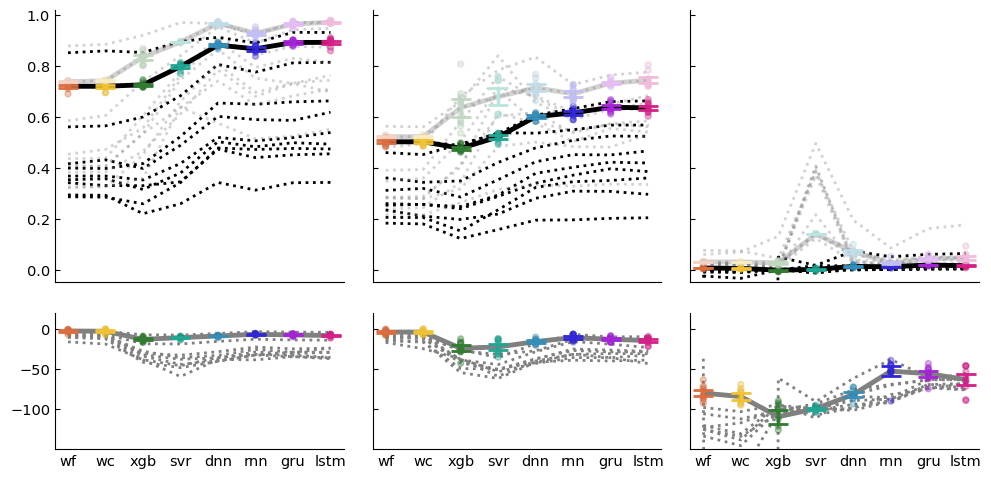

In [109]:
fig, axes = plt.subplots(2,3,figsize=(10,5), sharex=True, sharey='row',gridspec_kw={'height_ratios': [2, 1]}) #6,5.5
plt.rcParams.update({'font.size': 10.5})
fig.tight_layout()

#sessions = get_goodSessions(df,0.1,em='R2',val='R2_test_mn')
models = ['wf', 'wc', 'xgb', 'svr', 'dnn', 'rnn', 'gru', 'lstm']
#print(sessions)

for c, kin in enumerate(df['output'].unique()):
    for s,sess in enumerate(df['sess'].unique()): 
        wf_tr,wc_tr,xgb_tr,svr_tr,dnn_tr,rnn_tr,gru_tr,lstm_tr = get_dfVal_folds(df.loc[(df['sess']==sess)],o=kin,val='R2_train_mn')
        wf_te,wc_te,xgb_te,svr_te,dnn_te,rnn_te,gru_te,lstm_te = get_dfVal_folds(df.loc[(df['sess']==sess)],o=kin,val='R2_test_mn')

        for model in models:
            train_set = globals()[f'{model}_tr']
            test_set = globals()[f'{model}_te']
            globals()[f'{model}_gp'] = gen_gap(train_set, test_set)
                
        for q in range(3):
            if q==0:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm = wf_te,wc_te,xgb_te,svr_te,dnn_te,rnn_te,gru_te,lstm_te
                r = 0
            elif q==1:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm =  wf_tr,wc_tr,xgb_tr,svr_tr,dnn_tr,rnn_tr,gru_tr,lstm_tr
                r = 0
            else:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm =  wf_gp,wc_gp,xgb_gp,svr_gp,dnn_gp,rnn_gp,gru_gp,lstm_gp
                r = 1
                
            n=10
            means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])    
            err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

            ind = np.arange(len(err)) #X values for plotting
            if q==0:
                axes[r,c].plot(ind,means,color='black',alpha=1,linestyle='dotted',linewidth=2,label=s,zorder=0)
            elif q==1:
                axes[r,c].plot(ind,means,color='gray',alpha=0.35,linestyle='dotted',linewidth=2,label=s,zorder=0)
            else:
                axes[r,c].plot(ind,means,color='gray',alpha=1,linestyle='dotted',linewidth=2,label=s,zorder=0)
            
                
            if sess==29:
                n=10
                means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
                err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])
                
                ind = np.arange(len(err)) #X values for plotting

                if q==0:
                    axes[r,c].plot(ind,means,color='black',alpha=1,linestyle='solid',linewidth=3.5,label=s,zorder=2)
                    print(means)
                    thiscol = cols
                    zz = 3
                elif q==1:
                    axes[r,c].plot(ind,means,color='gray',alpha=0.35,linestyle='solid',linewidth=3.5,label=s,zorder=1)
                    thiscol = grays
                    zz = 2
                else:
                    axes[r,c].plot(ind,means,color='gray',alpha=1,linestyle='solid',linewidth=3.5,label=s,zorder=1)
                    thiscol = cols
                    zz = 3
                    
                    
                for pos, y, yerr, color in zip(ind, means, err, thiscol): #Loop through methods and plot error bars

                    axes[r,c].errorbar(pos, y, yerr, lw=2.5, capsize=7.5, capthick=2, color=color,zorder=zz)

                    axes[r,c].set_xticks([0,1,2,3,4,5,6,7])
                    axes[r,c].set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0)

                    #Remove right and top boundaries, and make ticks inward
                    axes[r,c].tick_params(direction='in',bottom=0)
                    axes[r,c].spines['right'].set_color('none')
                    axes[r,c].spines['top'].set_color('none')

                    #Plot individual R2 values for each fold as an 'x'
                    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(8)),(80,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
                    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting
                    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
                    for i in scatter_x.astype(int).reshape((1,-1))[0]:
                        colors_list.append(thiscol[i])

                    axes[r,c].scatter(scatter_x,scatter_y,c=colors_list,marker='.',s=70,alpha=0.05,zorder=2,edgecolors='face')

            if r==0:
                axes[r,c].set_ylim([-0.05,1.02])
                axes[r,c].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
            else:
                axes[r,c].set_ylim([-150,20])
                axes[r,c].set_yticks([0,-50,-100])
                
print(s)
plt.subplots_adjust(wspace=0.1, hspace=0.15)
fig.savefig(FIG_FOLDER+'/r2_allSessions.png', dpi=600, bbox_inches='tight')

# Figure 5. AMOUNT of data impact on accuracy/generalization

In [75]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[240,959], withTraces=False) # position

df.head(3)

,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,240,29,0,50,1,400,50,65,24,41,...,"[2.531397115853775, 2.535408542798284]","[0.6967174842812607, 0.7644170094397259]","[[0.8351590899362646, 0.8757743752053939]]","[2.6307275790573037, 2.5191258599695905]",0.730567,0.855467,2.574927,0.734125,0.856719,2.533403
1,240,29,0,50,1,400,50,65,24,41,...,"[2.523750275257502, 2.5343818001354315]","[0.6802569482005802, 0.7601311296566597]","[[0.8347804300673947, 0.8724204991320531]]","[2.693021762498249, 2.539350074554998]",0.720194,0.853600,2.616186,0.735837,0.857728,2.529066
2,240,29,0,50,1,400,50,65,24,41,...,"[2.5374785155470865, 2.5301053254158528]","[0.7072641973421873, 0.7534570128261007]","[[0.8464654241912434, 0.8749482222381165]]","[2.555384524576792, 2.5236440814437304]",0.730361,0.860707,2.539514,0.735455,0.857484,2.533792


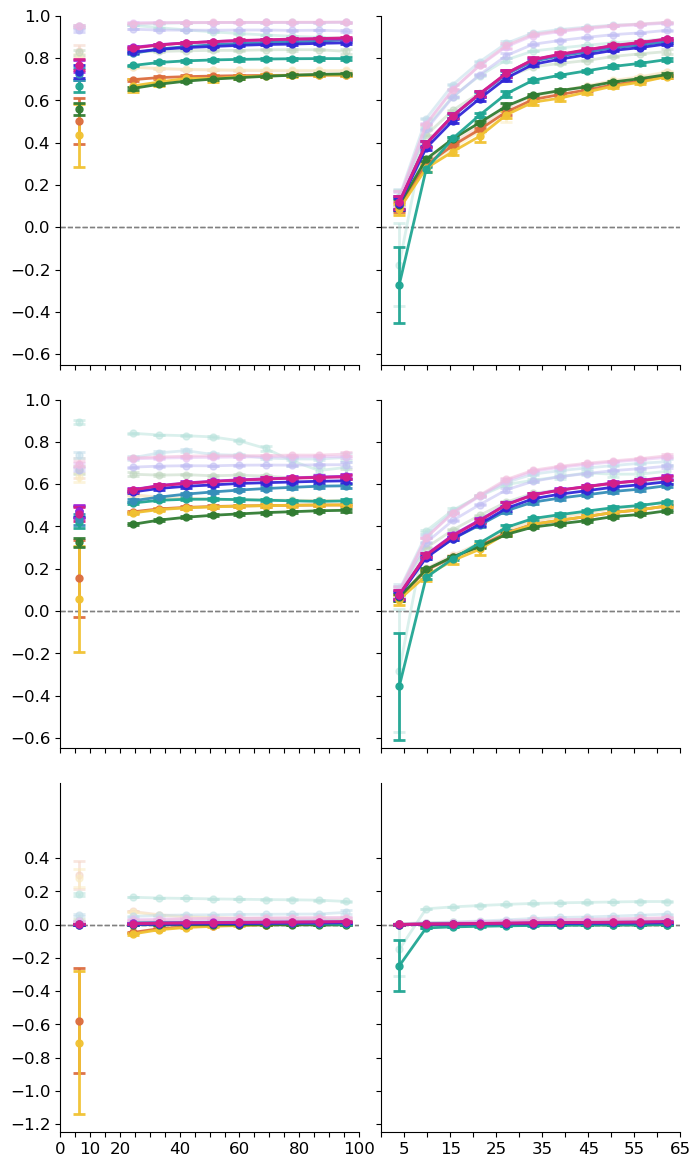

In [76]:
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(3, 2, figsize=(8, 14.5), sharex='col', sharey='row')#, gridspec_kw={'height_ratios': [3, 2]})

#plt.subplots_adjust(hspace=0.1)

################################### training set size ############################
kins = ['position','velocity','acceleration']
behs = ['R2_train_mn','R2_test_mn']
num_bins = 11

for k, kin in enumerate(kins):
    for b, beh in enumerate(behs):
        dff = df.loc[(df['output']==kin) & (df['nMT']==24) & (df['nFEF']==41)]
        dff = dff.copy()
        
        dff.loc[:, 'trainSet_dur'] = (dff['numObservations'] * dff['output_binWidth']) / (1000*60)
        dff.loc[:, 'trainSet_size'] = (dff['numObservations']/dff['numObservations'].max())*100
        #dff['trainSet_size'] = (dff['numObservations'] * dff['output_binWidth']) / (1000*60)
        dff = dff[dff[beh] >= -10]


        dff = dff[['model', 'trainSet_size', beh, 'outer_fold','repeat']]
        dff = dff.groupby(['model', 'trainSet_size', 'outer_fold'])[beh].mean().reset_index()
        obw = dff['trainSet_size'].unique()

        #df_mn = dff.groupby(['model', pd.qcut(dff['trainSet_size'], num_bins)])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', pd.qcut(dff['trainSet_size'], num_bins)])[beh].std().reset_index(name="sR2")

        df_mn = dff.groupby(['model', pd.cut(dff['trainSet_size'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
        df_sd = dff.groupby(['model', pd.cut(dff['trainSet_size'], bins=num_bins)])[beh].std().reset_index(name="sR2")

        
        #df_mn = dff.groupby(['model', 'trainSet_size'])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', 'trainSet_size'])[beh].std().reset_index(name="sR2")

        for i,m in enumerate(df['model'].unique()):
            if m < 9:
                mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
                mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

                bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)]['trainSet_size']]
                #bin_centers = obw
                
                if b==0:
                    ax[k,0].errorbar(bin_centers, mod_mn, mod_sd, lw=2, capsize=4, marker='o', alpha=0.55, markersize=5, capthick=2, color=grays[i], zorder=2)
                else:
                    ax[k,0].errorbar(bin_centers, mod_mn, mod_sd, lw=2, capsize=4, marker='o', alpha=0.95, markersize=5, capthick=2, color=cols[i], zorder=3)
                    
        ax[k,0].axhline(0, color='gray', linestyle='--',linewidth=1,zorder=0)  # Dashed line at y=0
                
        #ax[k,0].set_xscale('log')  # Set x-axis to log scale
        #ax[k,0].set_yscale('log')  # Set y-axis to log scale

        #x_tick_labels = [int(center) for center in bin_centers]
        #ax[k,0].set_xticks(bin_centers)
        #ax[k,0].set_xticklabels(x_tick_labels, rotation=0)

        ax[k,0].set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
        ax[k,0].set_xticklabels(['0','','10','','20','','','','40','','','','60','','','','80','','','','100'])

        # Set the x-tick labels as bin minimum and maximum for each point
        #x_tick_labels = obw
        #ax[k].set_xticks([0,0.2,0.4,0.6,0.8,1.0])
        #ax[k].set_xticklabels([0,20,40,60,80,100], rotation=0)
        #

    ax[k,0].spines['right'].set_color('none')
    ax[k,0].spines['top'].set_color('none')
    
################################### num neurons ############################
kins = ['position','velocity','acceleration']
behs = ['R2_train_mn','R2_test_mn']
num_bins = 11

for k, kin in enumerate(kins):
    for b, beh in enumerate(behs):
        dff = df.loc[(df['output']==kin) & (df['nMT']==99) & (df['nFEF']==99)]
        dff = dff.copy()
        #dff.loc[:, 'trainSet_size'] = (dff['numObservations'] * dff['output_binWidth']) / (1000*60)
        #dff['trainSet_size'] = (dff['numObservations'] * dff['output_binWidth']) / (1000*60)
        dff = dff[dff[beh] >= -10]


        dff = dff[['model', 'numNeurons', beh, 'outer_fold','repeat']]
        dff = dff.groupby(['model', 'numNeurons', 'outer_fold'])[beh].mean().reset_index()
        obw = dff['numNeurons'].unique()

        #df_mn = dff.groupby(['model', pd.qcut(dff['numNeurons'], num_bins)])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', pd.qcut(dff['numNeurons'], num_bins)])[beh].std().reset_index(name="sR2")

        df_mn = dff.groupby(['model', pd.cut(dff['numNeurons'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
        df_sd = dff.groupby(['model', pd.cut(dff['numNeurons'], bins=num_bins)])[beh].std().reset_index(name="sR2")
        
        #df_mn = dff.groupby(['model', 'numObservations'])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', 'numObservations'])[beh].std().reset_index(name="sR2")

        for i,m in enumerate(df['model'].unique()):
            if m < 9:
                mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
                mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

                bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)]['numNeurons']]
                
                if b==0:
                    ax[k,1].errorbar(bin_centers, mod_mn, mod_sd, lw=2, capsize=4, marker='o', alpha=0.55, markersize=5, capthick=2, color=grays[i], zorder=2)
                else:
                    ax[k,1].errorbar(bin_centers, mod_mn, mod_sd, lw=2, capsize=4, marker='o', alpha=0.95, markersize=5, capthick=2, color=cols[i], zorder=3)
                    

        #ax[k,1].set_xscale('log')  # Set x-axis to log scale
        #ax[k,1].set_yscale('log')  # Set y-axis to log scale

        #x_tick_labels = [int(center) for center in bin_centers]
        #ax[k,1].set_xticks(bin_centers)
        #ax[k,1].set_xticklabels(x_tick_labels, rotation=0)
                
        ax[k,1].set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65])
        ax[k,1].set_xticklabels(['','5','','15','','25','','35','','45','','55','','65'])
        # Set the x-tick labels as bin minimum and maximum for each point
        #x_tick_labels = obw
        #ax[k].set_xticks([0,0.2,0.4,0.6,0.8,1.0])
        #ax[k].set_xticklabels([0,20,40,60,80,100], rotation=0)
                
        ax[k,1].axhline(0, color='gray', linestyle='--',linewidth=1,zorder=0)  # Dashed line at y=0


    ax[k,1].spines['right'].set_color('none')
    ax[k,1].spines['top'].set_color('none')


ax[0,0].set_ylim([-0.65,1])
ax[1,0].set_ylim([-0.65,1])
ax[2,0].set_ylim([-1.25,0.85])

ax[0,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax[2,0].set_yticks([-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4])

    
plt.subplots_adjust(wspace=0.075, hspace=0.1)
fig.savefig(FIG_FOLDER+'/trainRatio_nn_r2.png', dpi=600, bbox_inches='tight')


# Figure 6. FORMAT of data (output bin width)

In [110]:
if 'plot_trials' not in locals(): 
    column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
    df, yp_test = get_outputs(DATA_FOLDER,["s29","r0001"],column_names,lrange=[0,239],withTraces=True) # position
    ya_test, c_test = get_actualTraces(DATA_FOLDER, df)

    # Get trial numbers for "best" trial in each direction, will be used for all eye traces plots
    #plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,o='position',fold=0,mdl=7,gi=13)
    plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,fold=0,o='acceleration',gi=1)
    print(plot_trls)
    
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, yp_test = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[960,1679],withTraces=True) # position
ya_test, c_test = get_actualTraces(DATA_FOLDER, df)

df.head(1)

[1068, 912, 938, 1015]


,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,960,29,0,10,1,400,50,65,24,41,...,"[2.542401093215621, 2.556934027092868]","[0.7063171623963362, 0.768587937204791]","[[0.8408104808807414, 0.8784322685462637]]","[2.632778748648657, 2.538956651771066]",0.737453,0.859621,2.585868,0.739657,0.859955,2.549668


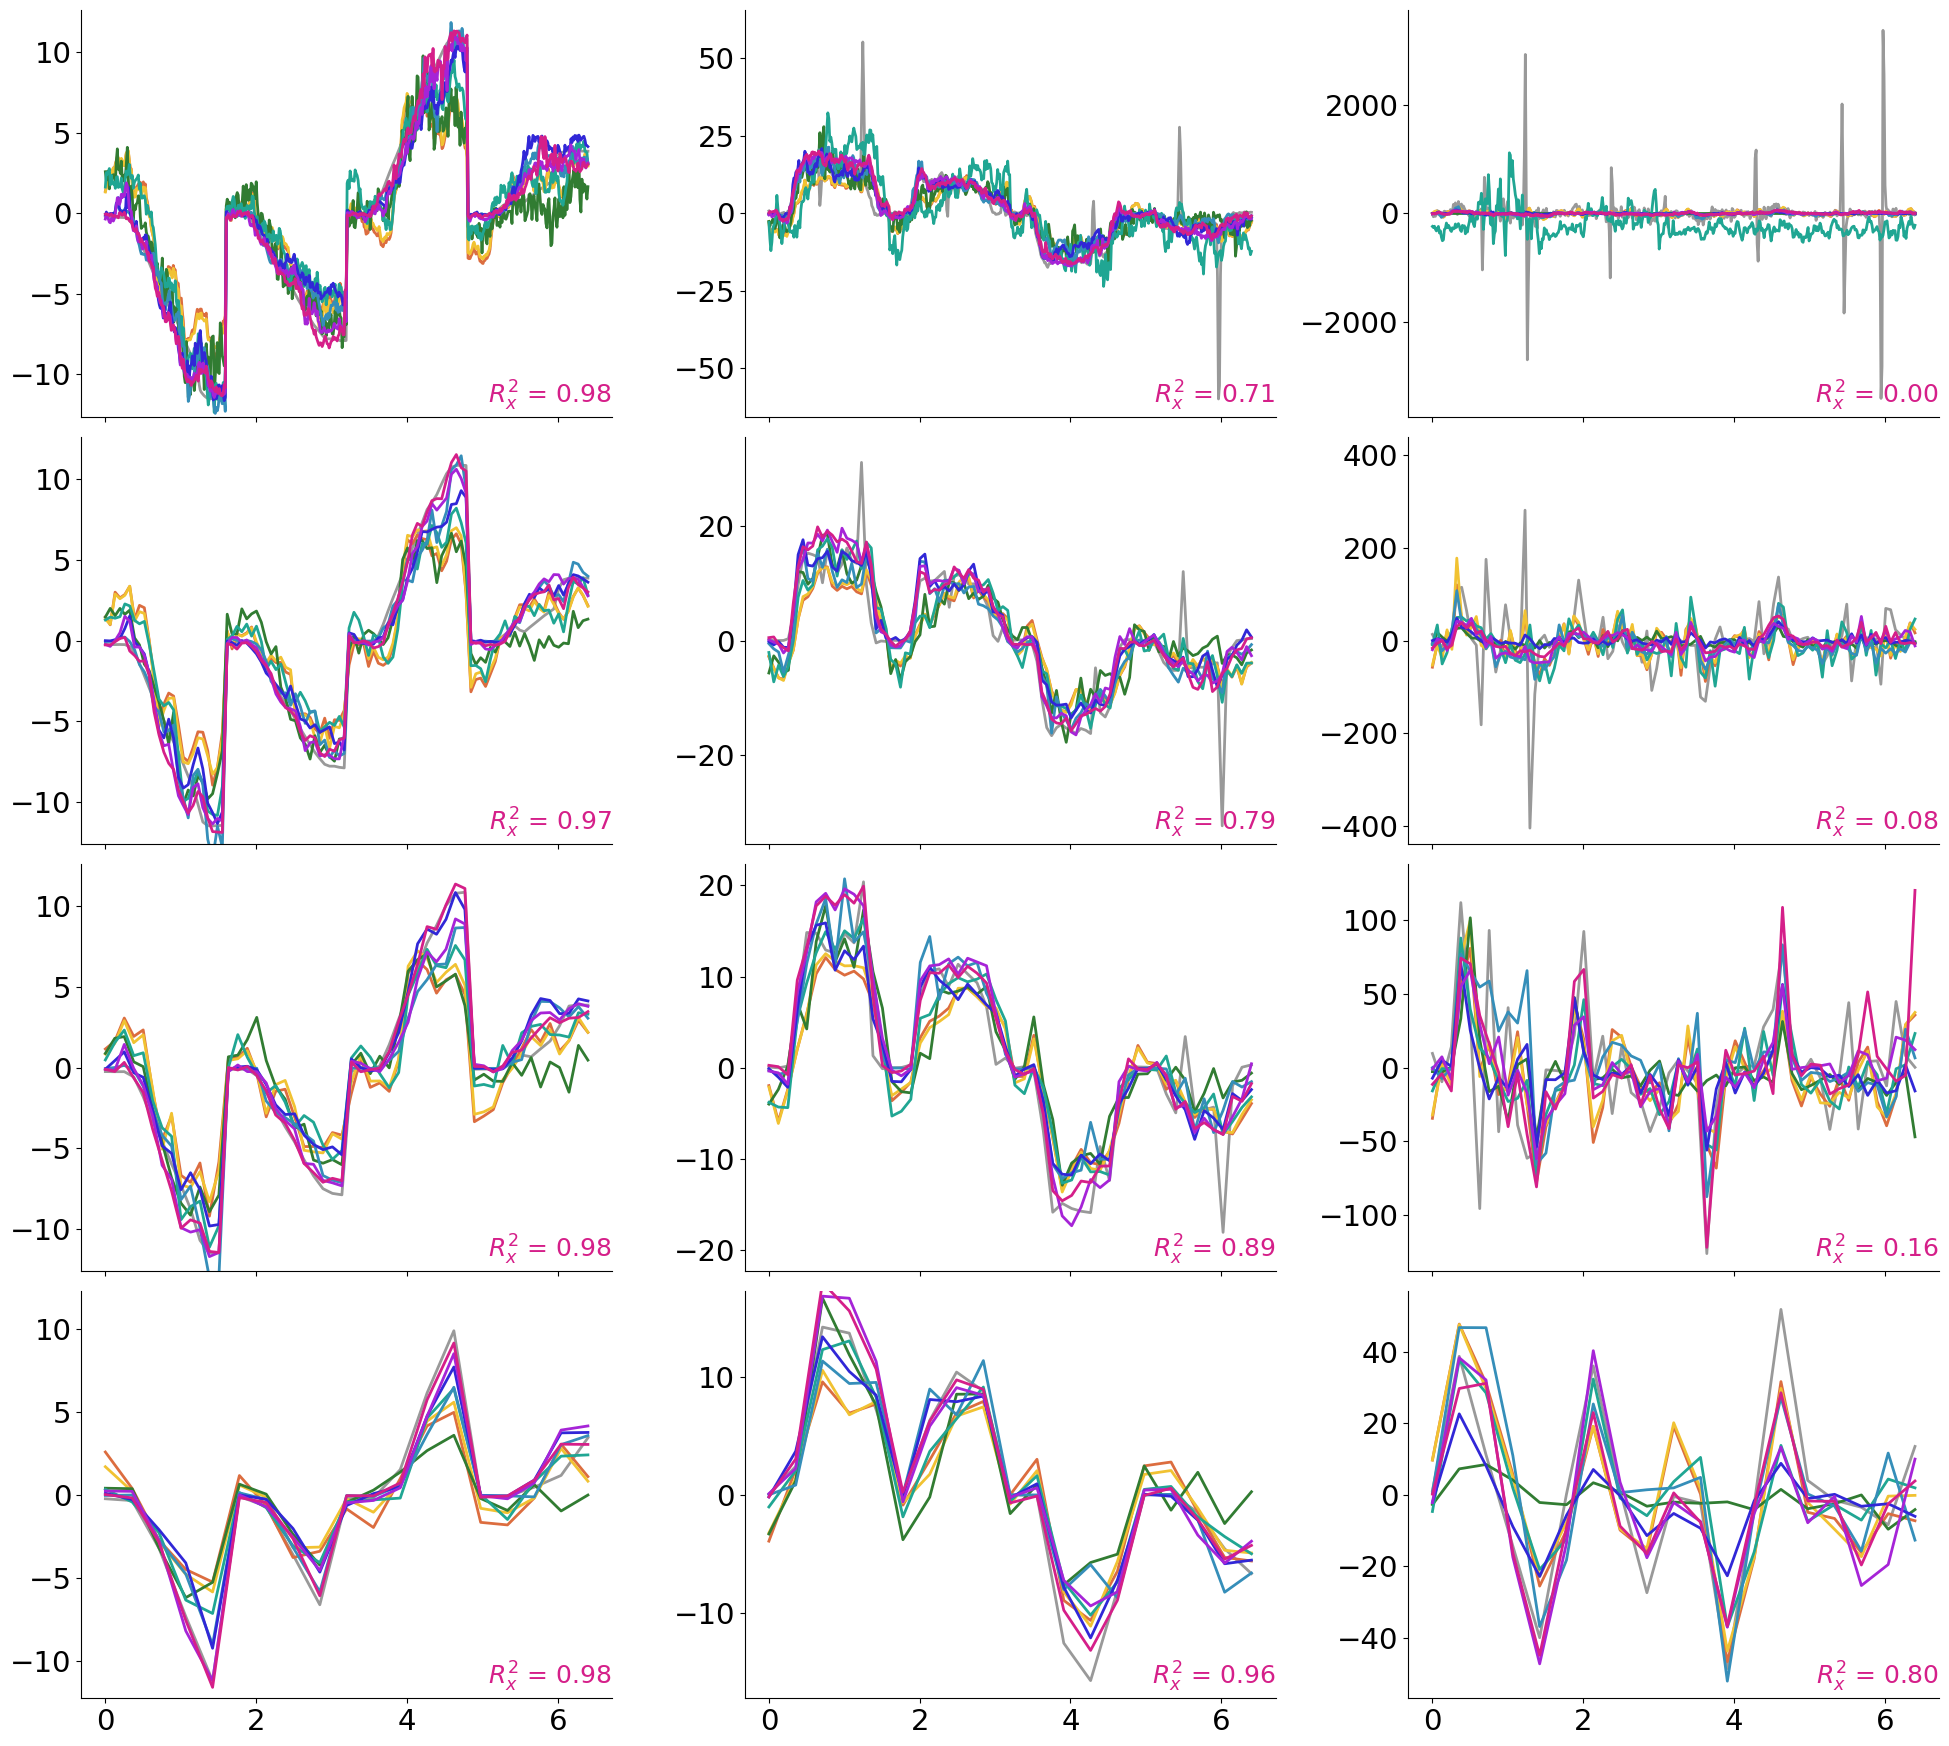

In [121]:
bws = [10,50,100,300]
lws = [2,2,2]

plt.rcParams.update({'font.size': 21})
fig, axes = plt.subplots(len(bws),3,figsize=(20,18), sharex=True, sharey=False)#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

for b, bw in enumerate(bws):
    for c, kin in enumerate(df['output'].unique()):
        for r, mod in enumerate(df['model'].unique()):
            y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,dto=bw,o=kin,mdl=mod,fold=0,trls=sorted(plot_trls))
            x = np.linspace(0,4*1.6,y_true.shape[0])

            if r==0:
                axes[b,c].plot(x,y_true[:,0],linewidth=lws[c],linestyle='solid',color=(0.6,0.6,0.6))
                #axes[b,c].plot(x,y_true[:,1],linewidth=lws[c],linestyle='dashed',color=(0.6,0.6,0.6))

            #if mod==3:
            #    axes[r,c].plot(x,y_pred[:,0]*np.std(y_true[:,0]),linewidth=lws[c],linestyle='solid',color=cols[r])
            #    axes[r,c].plot(x,y_pred[:,1]*np.std(y_true[:,1]),linewidth=lws[c],linestyle='dashed',color=cols[r])

            #    r2 = get_R2(y_true,y_pred * np.std(y_true,axis=0))

            #else:
            
            axes[b,c].plot(x,y_pred[:,0],linewidth=lws[c],linestyle='solid',color=cols[r])
            #axes[b,c].plot(x,y_pred[:,1],linewidth=lws[c],linestyle='dashed',color=cols[r])

            r2 = get_R2(y_true,y_pred)
            
            if mod==7:
                text_box = f"$R^2_x$ = {r2[0]:.2f}"
                axes[b,c].text(1, 0.01, text_box, transform=axes[b,c].transAxes, fontsize=18, ha='right', va='bottom', color=cols[r])

            axes[b,c].spines['right'].set_color('none')
            #axes[i].spines['bottom'].set_color('none')
            axes[b,c].spines['top'].set_color('none')
                
            # Set the y-axis limits to be centered on 0
            y_min, y_max = axes[b,c].get_ylim()
            max_abs_value = max(abs(y_min), abs(y_max))
            axes[b,c].set_ylim(-max_abs_value, max_abs_value)

axes[0,0].set_xticks([0,2,4,6])
            
plt.subplots_adjust(wspace=0.25, hspace=0.05)
fig.savefig(FIG_FOLDER+'/dtoTraces_8models_r2x.png', dpi=600, bbox_inches='tight')
    

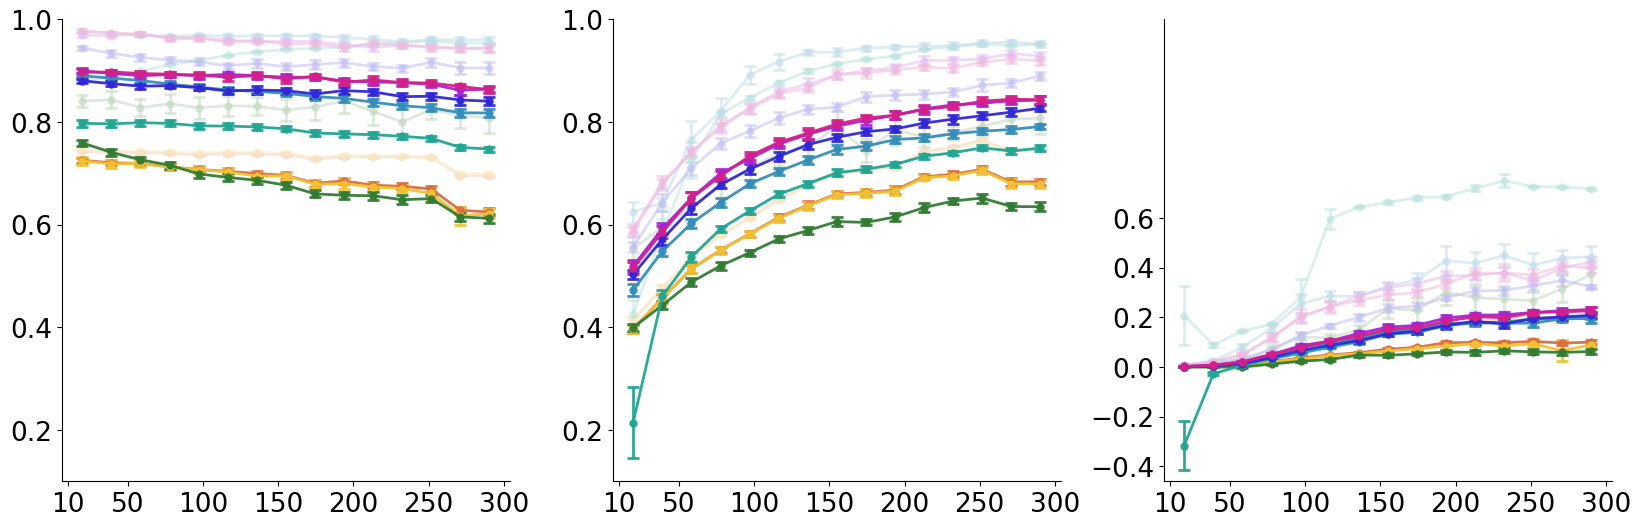

In [123]:
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 19})
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=False)#, gridspec_kw={'height_ratios': [3, 2]})

#plt.subplots_adjust(hspace=0.1)

################################### training set size ############################
kins = ['position','velocity','acceleration']
behs = ['R2_train_mn','R2_test_mn']
num_bins = 15

for k, kin in enumerate(kins):
    for b, beh in enumerate(behs):
        dff = df.loc[(df['output']==kin)]
        dff = dff.copy()
        
        #dff = dff[dff[beh] >= -10]

        dff = dff[['model', 'output_binWidth', beh, 'outer_fold','repeat']]
        dff = dff.groupby(['model', 'output_binWidth', 'outer_fold'])[beh].mean().reset_index()
        obw = dff['output_binWidth'].unique()

        #df_mn = dff.groupby(['model', pd.qcut(dff['trainSet_size'], num_bins)])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', pd.qcut(dff['trainSet_size'], num_bins)])[beh].std().reset_index(name="sR2")

        df_mn = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
        df_sd = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].std().reset_index(name="sR2")

        
        #df_mn = dff.groupby(['model', 'trainSet_size'])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', 'trainSet_size'])[beh].std().reset_index(name="sR2")

        for i,m in enumerate(df['model'].unique()):
            if m < 9:
                mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
                mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

                bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)]['output_binWidth']]
                #bin_centers = obw
                
                if b==0:
                    ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=2, capsize=4, marker='o', alpha=0.55, markersize=5, capthick=2, color=grays[i], zorder=2)
                else:
                    ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=2, capsize=4, marker='o', alpha=0.95, markersize=5, capthick=2, color=cols[i], zorder=3)
                    
                
                #ax[k,0].set_xscale('log')  # Set x-axis to log scale
                #ax[k,0].set_yscale('log')  # Set y-axis to log scale
                
                #x_tick_labels = [int(center) for center in bin_centers]
                #ax[k,0].set_xticks(bin_centers)
                #ax[k,0].set_xticklabels(x_tick_labels, rotation=0)
                
                #ax[k,0].set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
                #ax[k,0].set_xticklabels(['0','','10','','20','','','','40','','','','60','','','','80','','','','100'])
                
                # Set the x-tick labels as bin minimum and maximum for each point
                #x_tick_labels = obw
                ax[k].set_xticks([10,50,100,150,200,250,300])
                #ax[k].set_xticklabels([0,20,40,60,80,100], rotation=0)
                #

    ax[k].spines['right'].set_color('none')
    ax[k].spines['top'].set_color('none')
    
ax[0].set_ylim([0.1,1])
ax[1].set_ylim([0.1,1])
ax[2].set_ylim([-0.46,1.4])

ax[0].set_yticks([0.2,0.4,0.6,0.8,1.0])
ax[1].set_yticks([0.2,0.4,0.6,0.8,1.0])
ax[2].set_yticks([-0.4,-0.2,0,0.2,0.4,0.6])
    
plt.subplots_adjust(wspace=0.23, hspace=0.05)
fig.savefig(FIG_FOLDER+'/dto_8models_r2.png', dpi=600, bbox_inches='tight')

In [ ]:
# stats
from statsmodels.stats.anova import AnovaRM

num_bins = 15
kins = ['position', 'velocity', 'acceleration']

for k, kin in enumerate(kins):
    for i,m in enumerate(df['model'].unique()):
        DF = df.loc[(df['output'] == kin) & (df['model'] == m) & (df['output_binWidth']!=0) & (df['R2_mn'] >-1)]
        df_mn = DF.groupby([pd.cut(dff['output_binWidth'], bins=num_bins), 'outer_fold'])['R2_mn'].mean().reset_index()
        
        anova_model = AnovaRM(df_mn, 'R2_mn', 'outer_fold', within=['output_binWidth'])
        
        results = anova_model.fit()
        print('{}-{}'.format(kin,m))
        print(results)
        
        min_max_r2_values = df_mn.groupby('output_binWidth')['R2_mn'].agg(['min', 'max'])
        print(min_max_r2_values)

        # Extract the 'R2_mn' values for the smallest and largest 'output_binWidth'
        min_r2 = min_max_r2_values.loc[min_max_r2_values['R2_mn'].idxmin()]['R2_mn']
        max_r2 = min_max_r2_values.loc[min_max_r2_values['R2_mn'].idxmax()]['R2_mn']

        # Calculate the percent difference
        percent_difference = ((max_r2 - min_r2) / min_r2) * 100

        print(average_percent_difference)

        #df_sd = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].std().reset_index(name="sR2"

# Figure 7. FORMAT of data (input bin width & temporal context)

In [162]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[1680,8831],withTraces=False) # position

df.head(1)

,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,1680,29,0,50,1,10,10,65,24,41,...,"[7.119161257610029, 7.5018464247133805]","[0.06584261200207198, 0.13228921325637732]","[[0.28608006324282603, 0.3748402879945491]]","[7.609748194984091, 7.702064097140809]",0.099066,0.33046,7.655906,0.152019,0.389823,7.310504


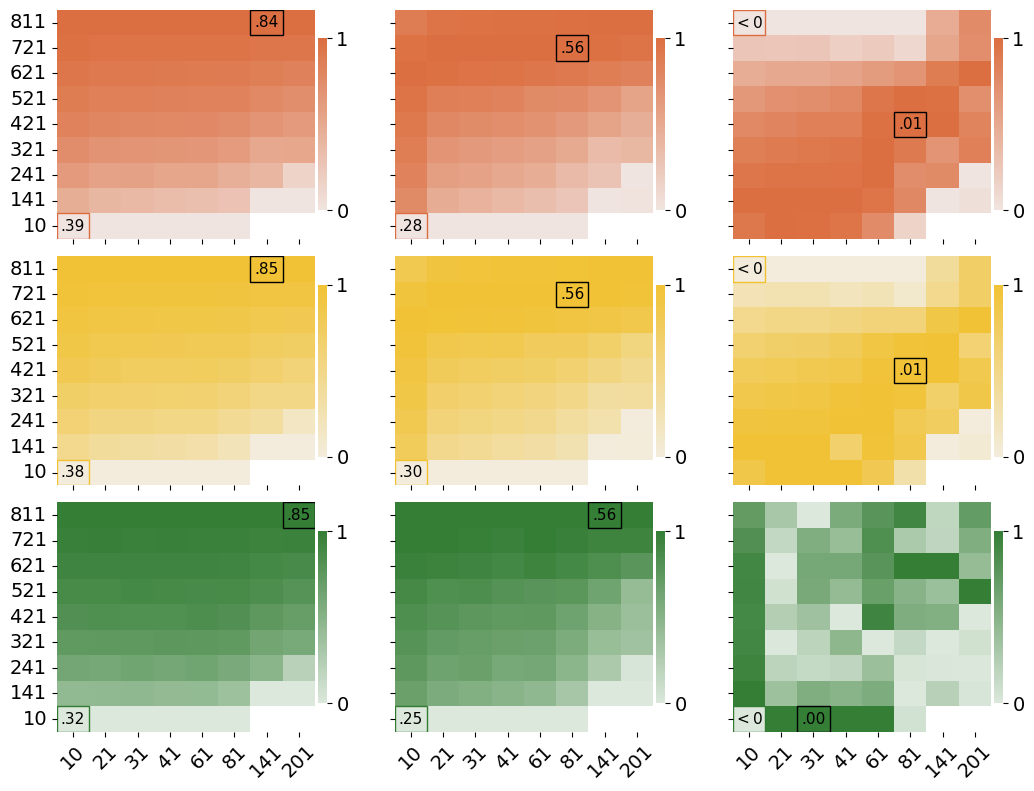

In [188]:
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from matplotlib.colors import TwoSlopeNorm

# Define the desired number of bins in x and y axes
desired_x_bins = 9 #9, 8
desired_y_bins = 9 #7, 8
mdls = ['wf','wc','kf','xgb','svr','dnn','rnn','gru','lstm']
beh = 'R2_test_mn'
cutType = 0

#################
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(len(df['model'].unique()),len(df['output'].unique()), figsize=(11,8), sharex=True, sharey=True) #(11,21)
fig.tight_layout()

for col, kin in enumerate(df['output'].unique()):    
    for i,m in enumerate(df['model'].unique()):
        DF = df.loc[(df['model']==m) & (df['output']==kin)]
        dff = DF[[beh,'input_binWidth','input_timeWindow']]
        
        if cutType==0:
            df_m = dff.groupby([
                pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
                pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
            ])[beh].mean().reset_index(name="R2")
        else:
            df_m = dff.groupby([
                pd.cut(dff['input_binWidth'], bins=desired_x_bins),
                pd.cut(dff['input_timeWindow'], bins=desired_y_bins)
            ])[beh].mean().reset_index(name="R2")

        # Pivot the data for heatmap
        result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
        
        R2_values = result.values.astype(float)
        # Normalize the values using Min-Max scaler
        scaler = MinMaxScaler()
        normalized_values = scaler.fit_transform(R2_values)
        result2 = result.copy()
        result2.loc[:, :] = normalized_values
        
        x_labels = [f'{int(col.left) + 1}' for col in result.columns]
        y_labels = [f'{int(index.left) + 1}' for index in result.index]

        a = sns.heatmap(ax=ax[i,col], data=result2, cmap=pals[i], mask=result2.isnull(), alpha=0.99,
                        robust=True, xticklabels=x_labels, yticklabels=y_labels, center=0.45,
                        cbar_kws={'location': 'right', 'ticks': [0, 1],
                                'orientation': 'vertical', 'pad': 0.01, "shrink": 0.75,
                                'format': ticker.FuncFormatter(lambda x, pos: f'{x:.0f}')})
        
        #

        for y in range(result.shape[0]):
            for x in range(result.shape[1]):
                value = result.iloc[y, x]
                if value >= 0:
                    display_value = f'{value:.2f}'.lstrip('0')
                else:
                    display_value = r'$\mathregular{{\mathit{{<}}}0}$'  # Use LaTeX formatting for smaller symbol
        
                if value == np.min(result.iloc[:, :-1]):
                    a.text(x+0.5, y+0.5, display_value, ha='center', va='center', color='black', fontsize=11)
                    a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor=cols[i], facecolor='none', lw=1))
                elif value == np.max(result):
                    a.text(x+0.5, y+0.5, display_value, ha='center', va='center', color='black', fontsize=11)
                    a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', lw=1))
                else:
                    blah = 0
                    #a.text(x+0.5, y+0.5, display_value, ha='center', va='center', color='white', fontsize=13)



        #, vmin=0.42, vmax=0.91,
        a.invert_yaxis()
        a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="center")

        a.set(xlabel=None)
        a.set(ylabel=None)
        
        
plt.subplots_adjust(wspace=0.1, hspace=0.075)
#fig.savefig(FIG_FOLDER+'/dti_heatmaps.png', dpi=600, bbox_inches='tight')


# Figure 8. Computational load

In [ ]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df1, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[240,575], withTraces=False) # trainSize
df2, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[576,959], withTraces=False) # numNeurons
df3, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[960,1679], withTraces=False) # outBins
df4, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[1680,8831], withTraces=False) # inBins

df1.head(3)

In [ ]:
from matplotlib.ticker import ScalarFormatter

num_bins = 12
behs = ['train_time','inference_time','robust_diff']
varbls = ['output_binWidth','num_feat','numNeurons']
kins = ['position','velocity']
lns = ['-','--','-.']
alphs = [1,0.6,0.3]

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(len(behs), len(varbls), figsize=(14, 22), sharex='col', sharey='row')#, gridspec_kw={'height_ratios': [3, 2]})
fig.tight_layout()

for v, vr in enumerate(varbls):
    if v==0:
        ddf = df0
    elif v==1:
        ddf = df1.loc[df1['input_binWidth']<=20]
    else:
        ddf = df2
        
    for n, kin in enumerate(kins):
        df = ddf.loc[ddf['output']==kin]

        for k, beh in enumerate(behs):
            dff = df[['model', vr, beh, 'outer_fold']]
            obw = dff[vr].unique()

            df_mn = dff.groupby(['model', pd.cut(dff[vr], bins=num_bins)])[beh].mean().reset_index(name="mR2")
            df_sd = dff.groupby(['model', pd.cut(dff[vr], bins=num_bins)])[beh].std().reset_index(name="sR2")

            for i,m in enumerate(df['model'].unique()):
                mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
                mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

                # Get the centers of the bins for x-values
                bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)][vr]]
                bin_mins = [bin.left for bin in df_mn[(df_mn['model'] == m)][vr]]
                bin_maxs = [bin.right for bin in df_mn[(df_mn['model'] == m)][vr]]

                # Round bin min and max values to the nearest integer
                bin_mins = [round(val) for val in bin_mins]
                bin_maxs = [round(val) for val in bin_maxs]

                ax[k,v].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, linestyle=lns[n], marker='o', alpha=alphs[n], markersize=7, capthick=2, color=cols[i], zorder=2)
                #ax[k,v].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, linestyle=lns[n], marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=3)

                x_tick_labels = [int(center) for center in bin_centers]
                x_tick_labels = [int(center) for i, center in enumerate(bin_centers)]

                #if v==0:
                #    x_tick_labels = [round((sess_size/x)/10000,1) for x in x_tick_labels]
                #    ax[k,v].invert_xaxis()

                ax[k, v].set_xticks(bin_centers)
                ax[k, v].set_xticklabels(x_tick_labels, rotation=45)

            ax[k,v].spines['right'].set_color('none')
            ax[k,v].spines['top'].set_color('none')
            
    #if v==0:
    #    ax[k,v].invert_xaxis()
    
    #ax[0,0].set_xticks(np.arange(20,320,60))
#ax[0,0].set_ylim([-40,450])
#ax[1,0].set_ylim([-0.6,8])

plt.subplots_adjust(wspace=0.25, hspace=0.05)
#fig.savefig(FIG_FOLDER+'/evalMetrics.png', dpi=600, bbox_inches='tight')